In [21]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import copy

import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")
import pandas as pd

<ipython-input-21-3242556460>:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [23]:
letterdata = torchvision.datasets.EMNIST(root = 'emnist', split = 'letters', download = True)
numberdata = torchvision.datasets.EMNIST(root = 'emnist', split = 'digits', download = True)

In [24]:
# transformations on the letter data

# remove N/A classes
letterCategories = letterdata.classes[1:]
labels = copy.deepcopy(letterdata.targets) - 1

# transform 4d tensor for conv layers (and transform from int8 to float)
letterImages = letterdata.data.view([letterdata.data.shape[0], 1, 28, 28]).float()
letterImages /= torch.max(letterImages)

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(letterImages, labels, test_size = .1)

# Step 3: convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
letter_train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
letter_test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [26]:
# transformations on numbers data

# transform to 4D tensor for conv layers (and transform from int8 to float)
numberImages = numberdata.data.view([numberdata.data.shape[0],1,28,28]).float()
numberImages /= torch.max(numberImages)


# split the images and convert to dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(numberImages, numberdata.targets, test_size=.1)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
number_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
number_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

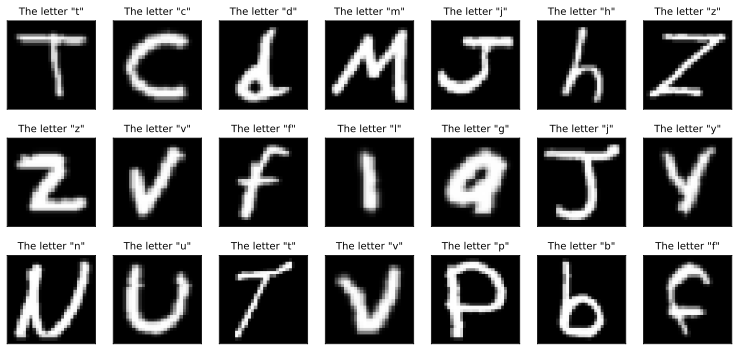

In [27]:
# visualize some letters
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of letter data
X,y = next(iter(letter_train_loader))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  letter = letterCategories[y[i]]

  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The letter "%s"'%letter,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

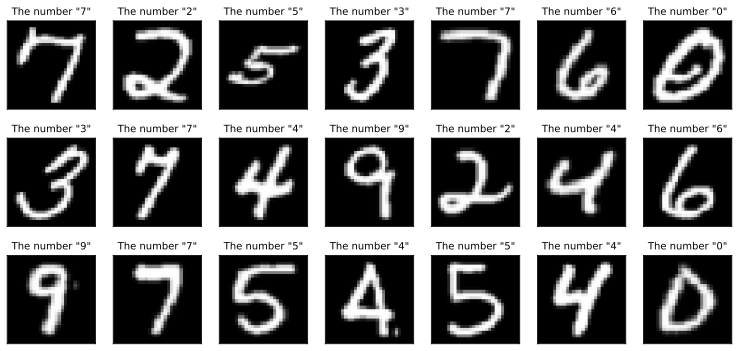

In [28]:
# visualize some numbers
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of number data
X,y = next(iter(number_train_loader))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  number = y[i].item()

  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The number "%s"'%number,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [29]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      # feature map layers
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # 6 = input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      # linear decision layers
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [30]:
# a function that trains the model

def trainTheModel(net, optimizer, train_loader, test_loader, numepochs = 10):

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    testErr = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchErr = []
        batchLoss = []
        for X, y in train_loader:

            # push data to the GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchErr.append(torch.mean((torch.argmax(yHat, axis = 1) != y).float()).item())
        # end loop

        # now that we've trained through the batches, get avg training accuracy
        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi] = 100*np.mean(batchErr)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))  # extract X, y from test dataloader

        # push data to the GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = net(X)
            loss = lossfun(yHat, y)

        # compute test accuracy
        testLoss[epochi] = loss.item()
        testErr[epochi] = 100*torch.mean((torch.argmax(yHat, axis = 1) != y).float()).item()
    # end epochs

    # function output
    return trainLoss, testLoss, trainErr, testErr, net

In [31]:
# create a new model
letterNet, lossfun, optimizer = makeTheNet()

trainLoss, testLoss, trainErr, testErr, letterNet = trainTheModel(letterNet, optimizer, letter_train_loader, letter_test_loader, 5)

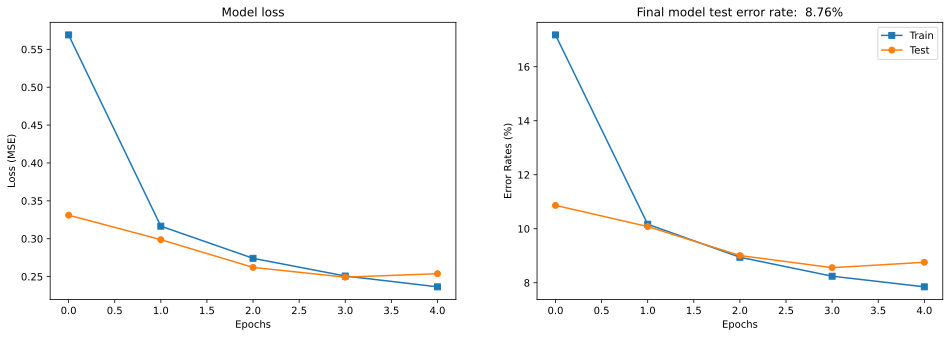

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label = 'Train')
ax[0].plot(testLoss, 'o-', label = 'Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr, 's-', label = 'Train')
ax[1].plot(testErr, 'o-', label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error Rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]: .2f}%')
ax[1].legend()

plt.show()

In [34]:
X, y = next(iter(number_test_loader))
X = X.to(device)
y = y.to(device)

letterNet.eval()
yHat = letterNet(X)

# the test
numberAcc = 100*torch.mean((torch.argmax(yHat, axis = 1) != y).float()).item()

print(f"numberNet error rate on NUMBER data: {numberAcc: .2f}%")

numberNet error rate on NUMBER data:  96.46%


In [36]:
# Fine tune the model with one training batch
numberNet, lossfun, optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target, source in zip(numberNet.named_parameters(), letterNet.named_parameters()):
  target[1].data = copy.deepcopy(source[1].data)

In [37]:
# check out the network
print(numberNet)
print(' ')

# and the final layer
print(numberNet.fc2)

# replace the final layer to have 10 outputs instead of 26
numberNet.fc2 = nn.Linear(50, 10)

# and check again
print(' ')
print(numberNet)

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)
 
Linear(in_features=50, out_features=26, bias=True)
 
emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [39]:
# train again since the last output layer was changed
trainLoss, testLoss, trainErr, testErr, numberNet = trainTheModel(numberNet, optimizer, number_train_loader, number_test_loader, 1)

In [40]:
print(f"numberNet TRAIN error rate: {trainErr[-1]: .2f}%")
print(f"numberNet TEST error rate: {testErr[-1]: .2f}%")

numberNet TRAIN error rate:  1.11%
numberNet TEST error rate:  0.95%


In [41]:
# Now freeze every layer except the output layer, which means train only the output layer and freeze convolution layer weights

# create the target model
numberNet2, lossfun, optimizer = makeTheNet()

# and then replace all the weights in TARGET model from SOURCE model
for target, source in zip(numberNet2.named_parameters(), letterNet.named_parameters()):
  target[1].data = copy.deepcopy(source[1].data)

# adjust number of output units
numberNet2.fc2 = nn.Linear(50, 10)

# freeze convolution and batch-norm layers
for p in numberNet2.named_parameters():
  if (('conv' in p[0]) or ('bnorm' in p[0])): # freeze all weights except output layer during training
    p[1].requires_grad = False

In [42]:
# train again since the last output layer was changed
trainLoss, testLoss, trainErr, testErr, numberNet2 = trainTheModel(numberNet2, optimizer, number_train_loader, number_test_loader, 1)

In [43]:
print(f"numberNet TRAIN error rate: {trainErr[-1]: .2f}%")
print(f"numberNet TEST error rate: {testErr[-1]: .2f}%")

numberNet TRAIN error rate:  2.94%
numberNet TEST error rate:  1.27%
